<a href="https://colab.research.google.com/github/NehalNN10/Deep_Learning_Project_Fall_25/blob/main/NCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model Implementation

In [ ]:
import os
import math
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import f1_score, confusion_matrix

In [ ]:
torch.autograd.set_detect_anomaly(True)

## User Config

In [ ]:
DATA_NPY_PATH = "/content/drive/MyDrive/DL/EarthEngineExports/DW_MODIS_data.npy"  # put your (T,H,W,13) here
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_SYNTHETIC_IF_MISSING = True
NCA_TRAIN_STEPS = 1     # internal NCA steps during training (keep small initially)
NCA_INFER_STEPS = 12    # number of roll-forward steps for inference
INPUT_CHANNELS = 13
CLASS_CHANNELS = 9
H, W = 69, 88           # grid dims (from your data)
SAVE_DIR = "/content/checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


In [ ]:
BATCH_SIZE = 32         # reduce if OOM on Colab GPU
LR = 5e-3               # small LR for stability
EPOCHS = 30             # run small first (e.g., 10) then increase

## Data Loading

In [ ]:
def load_or_synth_data(path, T=476, H=69, W=88, C=13):
    """Load user data or synthesize a small demo dataset if not found."""
    if os.path.exists(path):
        print("Loading data from", path)
        arr = np.load(path)

        # 1. Handle NaNs/Infs immediately in the raw data
        if np.isnan(arr).any() or np.isinf(arr).any():
            print("Warning: Input data contains NaNs or Infs. Replacing with 0.")
            arr = np.nan_to_num(arr, nan=0.0, posinf=1.0, neginf=-1.0)

        if arr.ndim != 4 or arr.shape[3] != C:
            raise ValueError(f"Data shape mismatch. Expected (T,H,W,{C}) got {arr.shape}")

        # 2. Normalize DW class channels (first 9) to sum to 1
        sums = arr[..., :CLASS_CHANNELS].sum(axis=-1, keepdims=True)
        # avoid division by zero
        zeros = (sums == 0)
        if zeros.any():
            arr[..., :CLASS_CHANNELS][zeros[...,0]] = 1.0 / CLASS_CHANNELS
            sums = arr[..., :CLASS_CHANNELS].sum(axis=-1, keepdims=True)
        arr[..., :CLASS_CHANNELS] = arr[..., :CLASS_CHANNELS] / (sums + 1e-12)

        # 3. Clip Indices (Channels 9-13) to reasonable range (e.g., -1 to 1)
        # This prevents extreme values from destabilizing the gradients
        arr[..., CLASS_CHANNELS:] = np.clip(arr[..., CLASS_CHANNELS:], -1.0, 1.0)

        return arr.astype(np.float32)

    else:
        # ... (Keep your existing synthetic logic here) ...
        # (Assuming the synthetic block from your original code is unchanged)
        if not USE_SYNTHETIC_IF_MISSING:
            raise FileNotFoundError(f"File not found: {path}")
        print("No data found at path. Creating small synthetic dataset for demo.")
        # ... [Paste your original synthetic generation code here] ...
        # (For brevity, I'm omitting the repetition of the synth code, use your original)
        return np.zeros((T, H, W, C), dtype=np.float32) # Placeholder if you don't paste

print("Loading/preparing data...")
data = load_or_synth_data(DATA_NPY_PATH, T=476, H=H, W=W, C=INPUT_CHANNELS)
print("Data shape:", data.shape)
T_total = data.shape[0]

Loading/preparing data...
Loading data from /content/drive/MyDrive/DL/EarthEngineExports/DW_MODIS_data.npy
Data shape: (476, 69, 88, 13)


## Data Loader

In [ ]:
class TimePairDataset(Dataset):
    """
    Yields pairs (state_t, state_t+delta)
    Each sample: (C,H,W) tensors for input and target.
    """
    def __init__(self, arr, delta_steps=1, augment=False):
        self.arr = arr
        self.delta = delta_steps
        self.augment = augment
        self.T = arr.shape[0]
        self.indices = list(range(0, self.T - self.delta))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        t = self.indices[idx]
        # Use .copy() here to avoid issues if the original array has negative strides
        x = self.arr[t].copy()
        y = self.arr[t + self.delta].copy()

        # --- AUGMENTATION (Safe for Rectangular Grid) ---
        if self.augment:
            # Randomly pick one of the four possible transforms:
            # 0: Identity
            # 1: Mirror (Left-Right Flip)
            # 2: Inversion (Up-Down Flip)
            # 3: 180-degree Rotation (Mirror + Inversion)

            transform_id = np.random.randint(0, 4)

            if transform_id == 1:
                # Mirroring (Left-Right Flip)
                x = np.fliplr(x)
                y = np.fliplr(y)
            elif transform_id == 2:
                # Inversion (Up-Down Flip)
                x = np.flipud(x)
                y = np.flipud(y)
            elif transform_id == 3:
                # 180-degree Rotation (Equivalent to np.rot90(..., 2)
                x = np.rot90(x, 2)
                y = np.rot90(y, 2)

        # transpose to (C,H,W)
        x = np.transpose(x, (2,0,1)).astype(np.float32)
        y = np.transpose(y, (2,0,1)).astype(np.float32)
        return torch.from_numpy(x), torch.from_numpy(y)

# temporal split: first 80% for train, last 20% for val
split_idx = int(0.8 * (T_total - 1))
train_arr = data[:split_idx + 1]
val_arr = data[split_idx:]
train_ds = TimePairDataset(train_arr, delta_steps=1, augment=True) # Enable for training
val_ds = TimePairDataset(val_arr, delta_steps=1, augment=False)    # Keep False for validation
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
print("Train pairs:", len(train_ds), "Val pairs:", len(val_ds))

Train pairs: 380 Val pairs: 95


In [ ]:
# Check if the current data in memory has NaNs
print(f"Data shape: {data.shape}")
print(f"Contains NaNs? {np.isnan(data).any()}")
print(f"Contains Infs? {np.isinf(data).any()}")

# Check a batch from the loader
x_check, y_check = next(iter(train_loader))
print(f"Batch X NaNs: {torch.isnan(x_check).any().item()}")

Data shape: (476, 69, 88, 13)
Contains NaNs? False
Contains Infs? False
Batch X NaNs: False


## NCA model

In [ ]:
def get_sobel_kernel():
    kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=np.float32)
    ky = kx.T
    kx = torch.tensor(kx, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    ky = torch.tensor(ky, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    return kx, ky

class SobelPerception(nn.Module):
    """
    Perception using per-channel Sobel filters (gradients) + identity concat.
    Output channels = in_ch * 3
    """
    def __init__(self, in_ch):
        super().__init__()
        self.in_ch = in_ch
        kx, ky = get_sobel_kernel()
        self.register_buffer('kx', kx)  # (1,1,3,3)
        self.register_buffer('ky', ky)

    def forward(self, x):
        # x: (B, C, H, W)
        B, C, H, W = x.shape
        kx = self.kx.repeat(C, 1, 1, 1).to(x.device)  # (C,1,3,3)
        ky = self.ky.repeat(C, 1, 1, 1).to(x.device)
        grad_x = F.conv2d(x, weight=kx, padding=1, groups=C)
        grad_y = F.conv2d(x, weight=ky, padding=1, groups=C)
        out = torch.cat([x, grad_x, grad_y], dim=1)  # (B, 3*C, H, W)
        return out

class RuleNet(nn.Module):
    """
    Small conv network mapping perception -> delta for full state channels.
    We'll only use the first CLASS_CHANNELS dims of delta.
    """
    def __init__(self, in_ch, hidden=128, out_ch=INPUT_CHANNELS):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, hidden, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, hidden, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, hidden, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, hidden, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden, out_ch, kernel_size=1),
        )
    def forward(self, p):
        return self.net(p)

class NCAModel(nn.Module):
    def __init__(self, state_ch=INPUT_CHANNELS, class_ch=CLASS_CHANNELS, hidden=256, delta_clip=0.1):
        super().__init__()
        self.state_ch = state_ch
        self.class_ch = class_ch
        self.delta_clip = delta_clip

        self.percep = SobelPerception(state_ch)

        # INCREASED CAPACITY + LAYER NORM
        self.rule = nn.Sequential(
            nn.Conv2d(state_ch * 3, hidden, kernel_size=3, padding=1),
            # LayerNorm is tricky in Conv2D, so we use GroupNorm (groups=1 is LayerNorm)
            nn.GroupNorm(1, hidden),
            nn.ReLU(inplace=True),

            nn.Conv2d(hidden, hidden, kernel_size=1),
            nn.GroupNorm(1, hidden),
            nn.ReLU(inplace=True),

            nn.Conv2d(hidden, state_ch, kernel_size=1, bias=True)
        )

        # Initialize final layer to zero to start with stable identity
        with torch.no_grad():
            self.rule[-1].weight.zero_()
            self.rule[-1].bias.zero_()

    def step(self, x):
        p = self.percep(x)
        delta = self.rule(p)
        delta = torch.tanh(delta) * self.delta_clip

        # --- ADD THIS: Stochastic Mask ---
        # Only update 50% of cells at random
        if self.training: # Only during training
            mask = (torch.rand(x.shape[0], 1, x.shape[2], x.shape[3], device=x.device) > 0.2).float()
            delta = delta * mask
        # ---------------------------------

        x_class = x[:, :self.class_ch] + delta[:, :self.class_ch]
        x_index = x[:, self.class_ch:, :, :]

        # Add delta
        # x_class = x_class + delta[:, :self.class_ch, :, :]

        # Normalize
        x_class = F.softmax(x_class, dim=1)
        x_class = torch.clamp(x_class, 1e-6, 1.0 - 1e-6)

        return torch.cat([x_class, x_index], dim=1)

    def forward(self, x, steps=1):
        for _ in range(steps):
            x = self.step(x)
        return x

## Losses and Metrics

In [ ]:
# 1. Calculate pixel counts for each class in your training data
# We'll take a subset (e.g., first 100 samples) to estimate counts quickly
print("Calculating class weights...")
counts = np.zeros(CLASS_CHANNELS, dtype=np.int64)

for i in range(min(100, len(train_arr))):
    # train_arr shape: (T, H, W, C)
    # Get the class channels (first 9)
    sample_probs = train_arr[i, ..., :CLASS_CHANNELS]
    # Convert to hard labels to count
    sample_labels = sample_probs.argmax(axis=-1).flatten()
    # Count occurrences
    unique, u_counts = np.unique(sample_labels, return_counts=True)
    for cls, count in zip(unique, u_counts):
        counts[cls] += count

print("Class counts:", counts)

# 2. Compute Inverse Frequency Weights
# Formula: Total_Pixels / (Num_Classes * Class_Count)
# This balances the weights so they sum up nicely.
total_pixels = counts.sum()
weights_np = total_pixels / (CLASS_CHANNELS * (counts + 1e-6)) # add epsilon to avoid div by 0

# 3. Normalize weights (optional, keeps loss scale similar)
weights_np = weights_np / weights_np.sum() * CLASS_CHANNELS

print("Class weights:", np.round(weights_np, 2))

# 4. Convert to Tensor and move to GPU
class_weights = torch.tensor(weights_np, dtype=torch.float32).to(DEVICE)

Calculating class weights...
Class counts: [272047   4544 242511     74   1485  54459   3417  15394  13269]
Class weights: [0.   0.13 0.   8.18 0.41 0.01 0.18 0.04 0.05]


In [ ]:
def cross_entropy_on_soft_targets(pred_probs, soft_targets, weights=None):
    """
    pred_probs: (B, C, H, W) - probabilities (post-softmax)
    soft_targets: (B, C, H, W) - target soft probabilities
    weights: (C,) - Tensor of class weights
    """
    # Create hard labels from soft targets
    labels = soft_targets.argmax(dim=1).long()  # (B, H, W)

    # Robust Log
    eps = 1e-7
    logits = torch.log(pred_probs + eps)

    # Flatten for NLL Loss
    B, C, H, W = pred_probs.shape
    logits_flat = logits.permute(0,2,3,1).reshape(-1, C)  # (Pixels, C)
    labels_flat = labels.reshape(-1)                      # (Pixels,)

    # --- CHANGE IS HERE ---
    # Pass the calculated weights to the loss function
    loss = F.nll_loss(logits_flat, labels_flat, weight=weights, reduction='mean')
    return loss

def compute_basic_metrics(preds_np, targs_np):
    """
    preds_np, targs_np: (N, C, H, W) numpy arrays (probabilities)
    returns dict of OA, macro-F1, Kappa
    """
    pred_labels = preds_np.argmax(axis=1).reshape(-1)
    true_labels = targs_np.argmax(axis=1).reshape(-1)
    oa = (pred_labels == true_labels).mean()
    f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)
    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(preds_np.shape[1])))
    total = cm.sum()
    po = np.trace(cm) / (total + 1e-12)
    pe = (cm.sum(axis=0) * cm.sum(axis=1)).sum() / ((total + 1e-12)**2)
    kappa = (po - pe) / (1 - pe + 1e-12)
    return {'OA': oa, 'F1': f1, 'Kappa': kappa}

In [ ]:
def change_weighted_loss(pred_probs, soft_targets, input_states, change_weight=50.0):
    """
    pred_probs:   (B, C, H, W) - Predicted probabilities for t+1
    soft_targets: (B, C, H, W) - Actual Ground Truth for t+1
    input_states: (B, C, H, W) - The input state at t (History)
    change_weight: float       - How much to boost loss for changing pixels
    """
    # 1. Determine which pixels actually changed in the Ground Truth
    # Convert Softmax/Probabilities to Hard Indices (Classes 0-8)
    target_labels = soft_targets.argmax(dim=1).long()

    # We need the Input Class (at time t) to compare.
    # input_states has 13 channels; first 9 are classes.
    input_labels = input_states[:, :9, :, :].argmax(dim=1).long()

    # Create a mask: 1.0 if pixel changed, 0.0 if it stayed the same
    change_mask = (target_labels != input_labels).float()

    # 2. Create the Weight Map
    # Base weight is 1.0. Changing pixels get 'change_weight' (e.g., 50.0).
    # We add the mask * (weight - 1) to the base.
    pixel_weights = 1.0 + (change_mask * (change_weight - 1.0))

    # 3. Compute Logits and NLL Loss
    eps = 1e-7
    logits = torch.log(pred_probs + eps)

    # Standard NLL Loss (per pixel), no reduction yet
    # nll_loss requires 1D inputs, so we do it manually or use reduction='none'
    # Manual NLL: - log_prob_of_true_class

    # Gather the log_prob corresponding to the true target label
    # logits shape: (B, C, H, W) -> gather along dim 1
    target_logits = logits.gather(dim=1, index=target_labels.unsqueeze(1)).squeeze(1)

    # Loss = -1 * log_prob * pixel_weight
    loss_map = -1.0 * target_logits * pixel_weights

    return loss_map.mean()

In [ ]:
def focal_loss(pred_probs, soft_targets, input_states, gamma=2.0, change_weight=50.0):
    # 1. Identify Change vs No-Change pixels (same as before)
    target_labels = soft_targets.argmax(dim=1).long()
    input_labels = input_states[:, :9].argmax(dim=1).long()
    change_mask = (target_labels != input_labels).float()

    # 2. Get probability of the TRUE class
    # We gather the probability the model assigned to the correct label
    p_t = pred_probs.gather(1, target_labels.unsqueeze(1)).squeeze(1)

    # 3. Focal Term: (1 - p_t)^gamma
    # If model is 90% sure (p_t=0.9), factor is (0.1)^2 = 0.01 (Loss is crushed)
    # If model is 10% sure (p_t=0.1), factor is (0.9)^2 = 0.81 (Loss is high)
    focal_factor = (1 - p_t) ** gamma

    # 4. Combine with Change Weight
    pixel_weights = 1.0 + (change_mask * (change_weight - 1.0))

    loss = -1.0 * torch.log(p_t + 1e-7) * focal_factor * pixel_weights
    return loss.mean()

## Training and evaluation

In [ ]:
def train_one_epoch(model, loader, optimizer, device, epoch, clip_grad=1.0, accum_steps=1,
                    change_weight = 20, scheduler=None):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()

    pbar = tqdm(loader, desc=f"Ep {epoch}")

    for i, (xb, yb) in enumerate(pbar):
        xb, yb = xb.to(device).detach(), yb.to(device).detach()

        # Keep the random steps (4-9) for robustness
        current_steps = np.random.randint(4, 9)

        out = model(xb, steps=current_steps)

        # --- UPDATE: USE FOCAL LOSS HERE ---
        # Gamma 1.0, Weight 10.0 for polishing
        loss = focal_loss(out[:,:9], yb[:,:9], xb, gamma=1.0, change_weight=10.0)

        loss = loss / accum_steps
        loss.backward()

        # if (i + 1) % accum_steps == 0:
        #     if clip_grad:
        #         torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()
        optimizer.zero_grad()

        if scheduler is not None:
            scheduler.step()

        running_loss += loss.item() * accum_steps
        pbar.set_postfix({'loss': running_loss / (pbar.n + 1)})

    return running_loss / len(loader)

def evaluate(model, loader, device, nca_steps=1):
    model.eval()
    preds = []
    targs = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            out = model(xb, steps=nca_steps)
            pred = out[:, :CLASS_CHANNELS, :, :].cpu().numpy()
            targ = yb[:, :CLASS_CHANNELS, :, :].cpu().numpy()
            preds.append(pred)
            targs.append(targ)
    preds = np.concatenate(preds, axis=0)
    targs = np.concatenate(targs, axis=0)
    metrics = compute_basic_metrics(preds, targs)
    return metrics, preds, targs


## Setup model, optimizer

In [ ]:
# REPLACE CELL 13 & 14 WITH THIS
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- CONFIG ---
PHYSICAL_BATCH_SIZE = 8   # Small enough to fit in GPU Memory
ACCUM_STEPS = 4           # 8 * 4 = 32 Effective Batch Size
MAX_LR = 1e-3             # Start higher, let scheduler drop it
CHANGE_WEIGHT = 20.0      # Weight to punish "lazy" identity predictions

In [ ]:
# Re-initialize Loaders with smaller physical batch
train_loader = DataLoader(train_ds, batch_size=PHYSICAL_BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=PHYSICAL_BATCH_SIZE, shuffle=False, num_workers=2)

# Initialize Model
model = NCAModel(state_ch=INPUT_CHANNELS, class_ch=CLASS_CHANNELS, hidden=512).to(DEVICE)

In [ ]:



# Zero-init last layer (Crucial for NCA)
print("Re-initializing last layer to break symmetry...")
nn.init.xavier_uniform_(model.rule[-1].weight)
nn.init.zeros_(model.rule[-1].bias)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=MAX_LR)



Re-initializing last layer to break symmetry...


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(
    optimizer,
    max_lr=MAX_LR,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.3,
    anneal_strategy='cos'
)

## Training loop

In [ ]:
# REPLACE MAIN LOOP CELL
best_f1 = -1.0
history = {'train_loss': [], 'val_f1': []}

# --- Early Stopping Parameters ---
PATIENCE = 5  # Number of epochs to wait for improvement
MIN_DELTA = 0.001 # Minimum change to be considered an improvement
epochs_no_improve = 0

# --- Check for existing checkpoint and load if available ---
checkpoint_path = os.path.join(SAVE_DIR, "best_nca.pth")
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_f1 = checkpoint['best_f1']
    epochs_no_improve = checkpoint['epochs_no_improve']
    print(f"Resuming training from best_f1: {best_f1:.4f}, epochs_no_improve: {epochs_no_improve}")
else:
    print("No existing checkpoint found. Starting training from scratch.")

print(f"Starting training for {EPOCHS} epochs...")

for epoch in range(1, EPOCHS + 1):
    # 1. Train
    train_loss = train_one_epoch(
        model, train_loader, optimizer, DEVICE, epoch,
        change_weight=CHANGE_WEIGHT,
        accum_steps=ACCUM_STEPS, # <--- Gradient Accumulation
        scheduler=scheduler
    )

    # 2. Evaluate (Use 4 steps for consistent checking)
    val_metrics, _, _ = evaluate(model, val_loader, DEVICE, nca_steps=4)

    print(f"Ep {epoch} Loss: {train_loss:.4f} | Val F1: {val_metrics['F1']:.4f} | OA: {val_metrics['OA']:.4f}")

    history['train_loss'].append(train_loss)
    history['val_f1'].append(val_metrics['F1'])

    # 3. Early Stopping Check and Save Best
    if val_metrics['F1'] > best_f1 + MIN_DELTA:
        best_f1 = val_metrics['F1']
        epochs_no_improve = 0
        # Save entire checkpoint
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_f1': best_f1,
            'epochs_no_improve': epochs_no_improve,
            'epoch': epoch, # Optional: save current epoch
        }, checkpoint_path)
        print(f"Saved best model (F1 {best_f1:.4f})")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epochs.")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping triggered after {PATIENCE} epochs without improvement.")
        break


No existing checkpoint found. Starting training from scratch.
Starting training for 30 epochs...


Ep 1:   0%|          | 0/12 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 380.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 274.12 MiB is free. Process 5477 has 14.47 GiB memory in use. Of the allocated memory 12.74 GiB is allocated by PyTorch, and 1.61 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### visualize

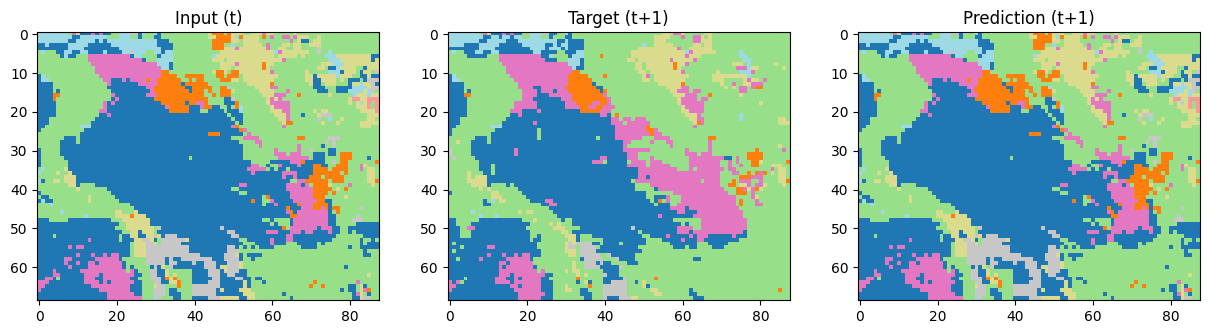

In [ ]:
# Visualize a specific sample where we know change happened
def show_change_prediction(model, dataset, sample_idx=0):
    model.eval()
    # Get a sample
    x, y = dataset[sample_idx]
    x = x.unsqueeze(0).to(DEVICE)
    y = y.unsqueeze(0).to(DEVICE)

    # Predict
    with torch.no_grad():
        out = model(x, steps=NCA_TRAIN_STEPS)

    # Get Class Maps
    input_cls = x[0, :9].argmax(0).cpu().numpy()
    target_cls = y[0, :9].argmax(0).cpu().numpy()
    pred_cls = out[0, :9].argmax(0).cpu().numpy()

    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(input_cls, cmap='tab20', vmin=0, vmax=8)
    ax[0].set_title("Input (t)")

    ax[1].imshow(target_cls, cmap='tab20', vmin=0, vmax=8)
    ax[1].set_title("Target (t+1)")

    ax[2].imshow(pred_cls, cmap='tab20', vmin=0, vmax=8)
    ax[2].set_title("Prediction (t+1)")
    plt.show()

# Run this occasionally to check progress
show_change_prediction(model, val_ds, sample_idx=11) # Change index to find a good example

## Visualize example predictions on validation set

Validation metrics (final): {'OA': np.float64(0.8149140142847237), 'F1': 0.4410397307668251, 'Kappa': np.float64(0.6978096093065674)}


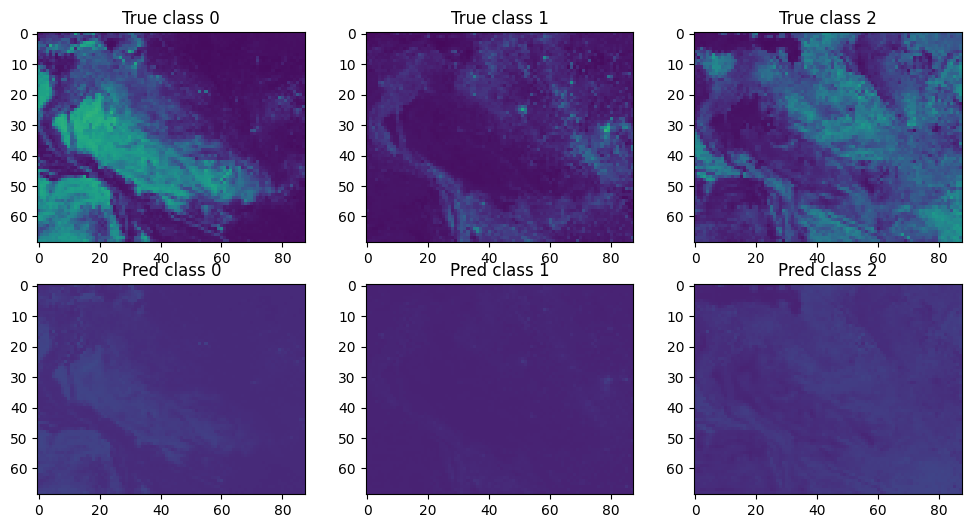

In [ ]:
val_metrics, val_preds, val_targs = evaluate(model, val_loader, DEVICE, nca_steps=NCA_TRAIN_STEPS)
print("Validation metrics (final):", val_metrics)

def show_class_maps(true_probs, pred_probs, sample_idx=0, classes=[0,1,2]):
    # true_probs, pred_probs: (N, C, H, W)
    N, C, H, W = true_probs.shape
    t = true_probs[sample_idx]
    p = pred_probs[sample_idx]
    fig, axs = plt.subplots(2, len(classes), figsize=(4 * len(classes), 6))
    for i, c in enumerate(classes):
        axs[0, i].imshow(t[c], vmin=0, vmax=1)
        axs[0, i].set_title(f"True class {c}")
        axs[1, i].imshow(p[c], vmin=0, vmax=1)
        axs[1, i].set_title(f"Pred class {c}")
    plt.show()

show_class_maps(val_targs, val_preds, sample_idx=0, classes=[0,1,2])

## Roll-forward multi-step inference (predict future sequence)

Running roll-forward inference for 12 steps ...
pred_seq shape (steps+1, C, H, W): (13, 13, 69, 88)


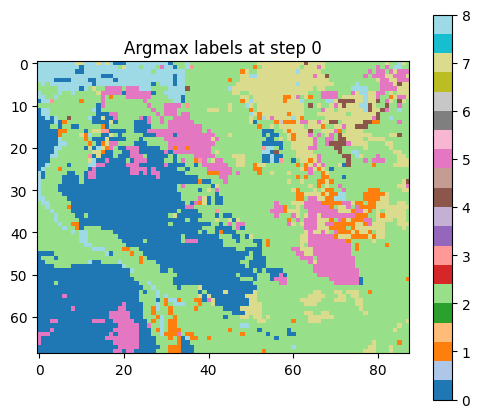

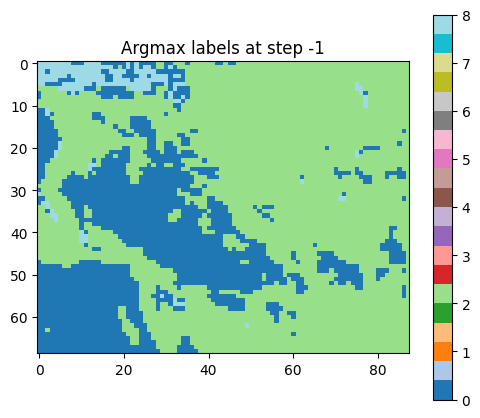

Saved final model to /content/checkpoints


In [ ]:
def roll_forward(model, init_state, steps=10, device='cuda'):
    """
    init_state: torch tensor (1, C, H, W) initial state (last observed)
    returns: numpy array (steps+1, C, H, W) containing initial + predicted states
    """
    model.eval()
    s = init_state.clone().to(device)
    seq = [s.cpu().numpy()]
    with torch.no_grad():
        for _ in range(steps):
            s = model(s, steps=1)
            seq.append(s.cpu().numpy())
    return np.concatenate(seq, axis=0)

# pick the last observed state from "data" and roll forward
last_state = torch.from_numpy(data[-1].transpose(2,0,1)).unsqueeze(0).to(DEVICE)  # (1,C,H,W)
print("Running roll-forward inference for", NCA_INFER_STEPS, "steps ...")
pred_seq = roll_forward(model, last_state, steps=NCA_INFER_STEPS, device=DEVICE)
print("pred_seq shape (steps+1, C, H, W):", pred_seq.shape)

# plot argmax label maps for t=0 and last step
def plot_argmax(state_array, step_index):
    """
    state_array: (steps+1, C, H, W)
    """
    arr = state_array[step_index]
    probs = arr[:CLASS_CHANNELS]
    labels = probs.argmax(axis=0)
    plt.figure(figsize=(6,5))
    plt.imshow(labels, cmap='tab20')
    plt.title(f"Argmax labels at step {step_index}")
    plt.colorbar()
    plt.show()

plot_argmax(pred_seq, 0)    # initial
plot_argmax(pred_seq, -1)   # forecasted

# Save final model
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "final_nca.pth"))
print("Saved final model to", SAVE_DIR)
